# ALOS/ALOS2 PALSAR Annual Mosaics <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


* **Products used:** 
[alos_palsar_mosaic](https://explorer.digitalearth.africa/products/alos_palsar_mosaic),
[jers_sar_mosaic](https://explorer.digitalearth.africa/products/jers_sar_mosaic)

## Background

The ALOS/ALOS2 PALSAR is a global 25 m resolution dataset that combines data from many images captured by JAXA’s PALSAR and PALSAR-2 sensors on ALOS-1 and ALOS-2 satellites respectively. This product contains radar measurement in L-band and in HH and HV polarizations. It has a spatial resolution of 25m and is available annually for 2007 to 2010 (ALOS/PALSAR) and 2015 to 2018 (ALOS-2/PALSAR-2).
ALOS/ALOS2 PALSAR mosaic data is part of a global [dataset](https://www.eorc.jaxa.jp/ALOS/en/palsar_fnf/fnf_index.htm) provided by the Japan Aerospace Exploration Agency (JAXA) Earth Observation Research Center. Historically, the JERS annual mosaic is generated from images acquired by the SAR sensor on the Japanese Earth Resources Satellite-1 (JERS-1) satellite. 

DE Africa's ALOS/ALOS-2 PALSAR/PALSAR-2 and JERS annual mosaic are Normalized Radar Backscatter data, for which Radiometric Terrain Correction (RTC) has been applied so data acquired with different imaging geometries over the same region.The relevant coverage and metadata of ALOS/ALOS2 PALSAR dataset can be viewed on [DE Africa Metadata Explorer](https://explorer.dev.digitalearth.africa/products/alos_palsar_mosaic/extents) while JERS dataset coverage can be access via this [link](https://explorer.dev.digitalearth.africa/products/jers_sar_mosaic) that forms a single, cohesive Analysis Ready Data (ARD) package, which allows you to analyse radar backscatter data as-is without the need to apply additional corrections.

**Important details:**

* ALOS/ALOS2 PALSAR annual mosaic product specifications

    * Number of bands: `5`
    * To achieve backscatter in decibel unit, convert backscatter values in Digital Number (DN) using $ 10 * log10(DN^2) - 83.0 $
    * Mask specification includes `0` for `no-data`, `50` for water, `100` for lay_over, `150` for shadowing and `255` for land
    * Native pixel alignment is `centre`
    * Date-range: selected years from 2007 to 2018
    * Spatial resolution: 25 x 25 m
    
* JERS annual mosaic product specifications

    * Number of bands: `4`
    * To achieve backscatter in decibel unit, convert backscatter values in Digital Number (DN) using $ 10 * log10(DN^2) - 84.66 $
    * Mask specification includes `0` for `no-data`, `50` for water, `100` for lay_over, `150` for shadowing and `255` for land
    * Native pixel alignment is `centre`
    * Date-range: 1996
    * Spatial resolution: 25 x 25 m

For a detailed description of DE Africa's ALOS/ALOS2 PALSAR archive, see the DE Africa's [ALOS/ALOS2 technical specifications documentation](https://docs.digitalearthafrica.org/en/latest/data_specs/ALOS_PALSAR_JERS_mosaic_specs.html).

## Description

In this notebook we will load **ALOS PALSAR** data using [dc.load()](../Beginners_guide/03_Loading_data.ipynb) to return a time series of satellite images from a single sensor.

Topics covered include:
1. Inspecting the ALOS PALSAR products and measurements available in the datacube
2. Using the native `dc.load()` function to load in dual polarization ALOS PALSAR data and visualize
3. Using `dc.load()` function to load single polarization JERS mosaic and visualize

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
%matplotlib inline
import datacube
import sys
import math 
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from xarray.ufuncs import isfinite

from deafrica_tools.plotting import rgb 
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="ALOS")

## Available products and measurements

### List products

We can use datacube's `list_products` functionality to inspect DE Africa's SAR products that are available in the datacube. The table below shows the product names that we will use to load the data, a brief description of the data, and the satellite instrument that acquired the data.

In [3]:
productA = "alos_palsar_mosaic"

### List measurements

We can further inspect the data available for each SAR product using datacube's `list_measurements` functionality. The table below lists each of the measurements available in the data.

In [4]:
measurements = dc.list_measurements()
measurements.loc[productA]

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
hh,hh,int16,1,0,[hh],NaN
hv,hv,int16,1,0,[hv],NaN
date,date,int16,1,0,[date],NaN
linci,linci,uint8,1,0,"[local incidence angle, linci, incidence]",NaN
mask,mask,uint8,1,0,[mask],"{'category': {'bits': [0, 1, 2, 3, 4, 5, 6, 7]..."


## Load ALOS PALSAR dataset using `dc.load()`

Now that we know what products and measurements are available for the products, we can load data from the datacube using `dc.load`.

In the example below, we will load ALOS PALSAR for Cairo and its surrounding in Egypt between 2007 and 2018. 

We will load data from three spectral satellite bands, as well as masked data (`'mask'`). By specifying `output_crs='EPSG:6933'` and `resolution=(-25, 25)`, we request that datacube reproject our data to the NSIDC EASE-Grid 2.0 Global coordinate reference system (CRS), with 25 x 25 m pixels. If these options are not set, the data will be loaded in native EPSG:4326 CRS.

> Note: For a more general discussion of how to load data using the datacube, refer to the [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb) notebook.



In [5]:
# Setting the query for area in the proximity of Cairo 
lon = (31.90, 32.10)
lat = (30.37, 30.55)
query = {"x": lon,
         "y": lat,
         "output_crs": 'epsg:6933',
         "resolution":(-25,25),
         "time": ("2007", "2018")}

### Visualise the selected area 

In [6]:
display_map(x=lon, y=lat)

In [ ]:
#loading the data with the mask band included 
bands = ['hh','hv','mask']
ds_ALOS = dc.load(product='alos_palsar_mosaic',
             measurements=bands,
             **query)

print(ds_ALOS)

In [8]:
#creation of a new band (HV/HH = hvhh) for RGB display 
ds_ALOS['hvhh'] = ds_ALOS.hv / ds_ALOS.hh

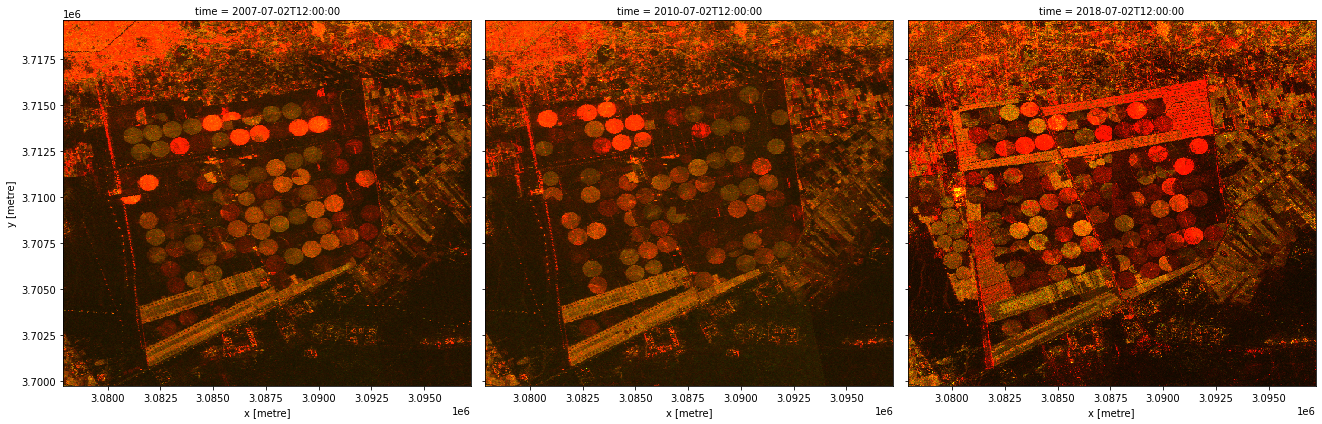

In [9]:
# Set the timesteps to visualise
timesteps = [0,3,7]

# Generate RGB plots at each timestep
rgb(ds_ALOS, bands=['hh','hv','hvhh'], index=timesteps)

### Coverting DN Values to Decibel Units 

Since Backscatter data is provided as digital number(DN), it can be converted to backscatter in decibel unit to enhance contrast using the provided conversion equation. Before converting to decibel, we also apply the data mask to exclude pixels in radar shadow or with layerover.

In [10]:
#convert DN to db values
ds_ALOS['hh_db'] =  10 * np.log10(ds_ALOS.hh.where(ds_ALOS.mask.isin([50,255]))**2) - 83.0
ds_ALOS['hv_db'] =  10 * np.log10(ds_ALOS.hv.where(ds_ALOS.mask.isin([50,255]))**2) - 83.0
ds_ALOS['hvhh_db'] = ds_ALOS['hv_db'] - ds_ALOS ['hh_db']

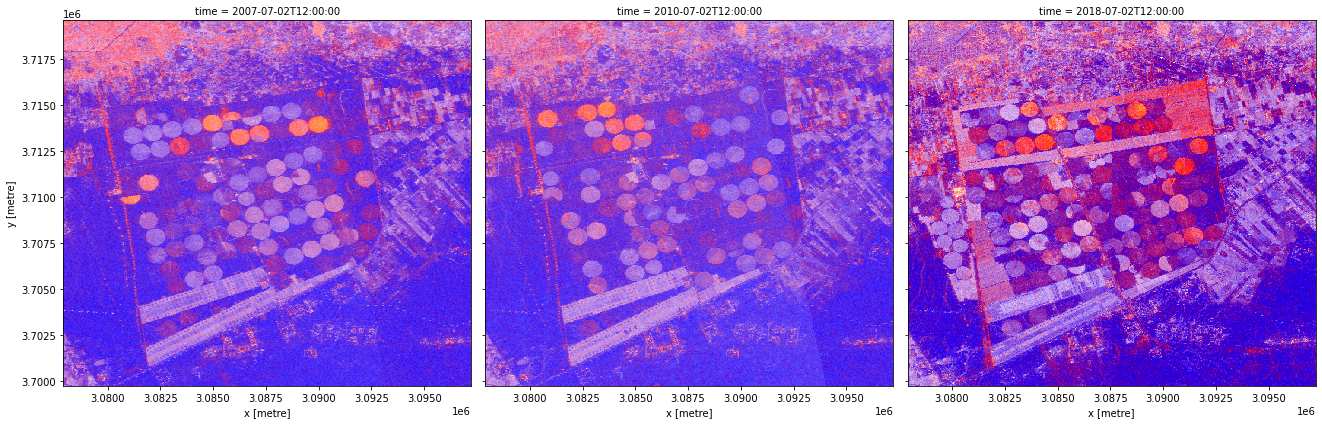

In [11]:
# Set the timesteps to visualise
timesteps = [0,3,7]

# Generate RGB plots at each timestep
rgb(ds_ALOS, bands=['hh_db','hv_db','hvhh_db'], index=timesteps)

## Histogram Analysis for ALOS/ALOS2 PALSAR Dataset 

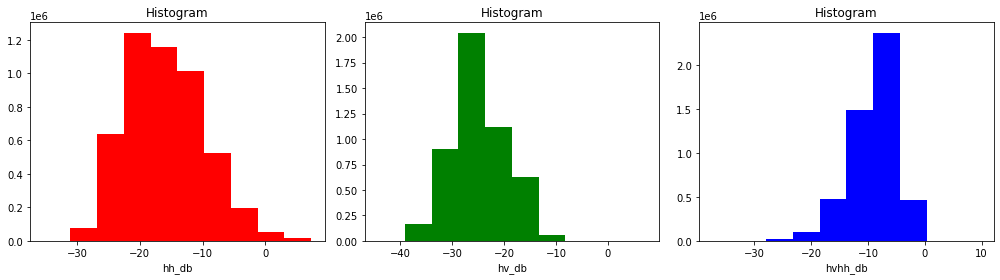

In [12]:
#plotting each polorisation bands following converting to dB values 
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ds_ALOS.hh_db.plot.hist(ax=ax[0], facecolor='red')
ds_ALOS.hv_db.plot.hist(ax=ax[1], facecolor='green')
ds_ALOS.hvhh_db.plot.hist(ax=ax[2], facecolor='blue')
plt.tight_layout()
plt.show()

## Load JERS dataset using `dc.load()`

In the example below, we will load JERS annual mosaic for Cairo and its surrounding in Egypt in 1996. 

We will load data from HH polarization band as well as the data mask (`'mask'`). By specifying `output_crs='EPSG:6933'` and `resolution=(-25, 25)`, we request that datacube reproject our data to the NSIDC EASE-Grid 2.0 Global coordinate reference system (CRS), with 25 x 25 m pixels. 

> Note: For a more general discussion of how to load data using the datacube, refer to the [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb) notebook.

In [13]:
# Setting the query for area in the proximity of Cairo 
lon = (31.90, 32.10)
lat = (30.37, 30.55)
query_jers = {"x": lon,
         "y": lat,
         "output_crs": 'epsg:6933',
         "resolution":(-25,25),
         "time": ("1996")}


In [14]:
#loading the data with the mask band included 
bands = ['hh','mask']
ds_JERS = dc.load(product='jers_sar_mosaic',
             measurements=bands,
             **query_jers)

print(ds_JERS)

<xarray.Dataset>
Dimensions:      (time: 1, x: 773, y: 795)
Coordinates:
  * time         (time) datetime64[ns] 1996-07-02
  * y            (y) float64 3.72e+06 3.72e+06 3.72e+06 ... 3.7e+06 3.7e+06
  * x            (x) float64 3.078e+06 3.078e+06 ... 3.097e+06 3.097e+06
    spatial_ref  int32 6933
Data variables:
    hh           (time, y, x) int16 5367 4466 4974 4974 ... 2803 3171 2750 2752
    mask         (time, y, x) uint8 255 255 255 255 255 ... 255 255 255 255 255
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


In [15]:
#convert DN values in JERS dataset to db values
ds_JERS['hh_db'] =  10 * np.log10(ds_JERS.hh.where(ds_JERS.mask.isin([50,255]))**2) - 84.66

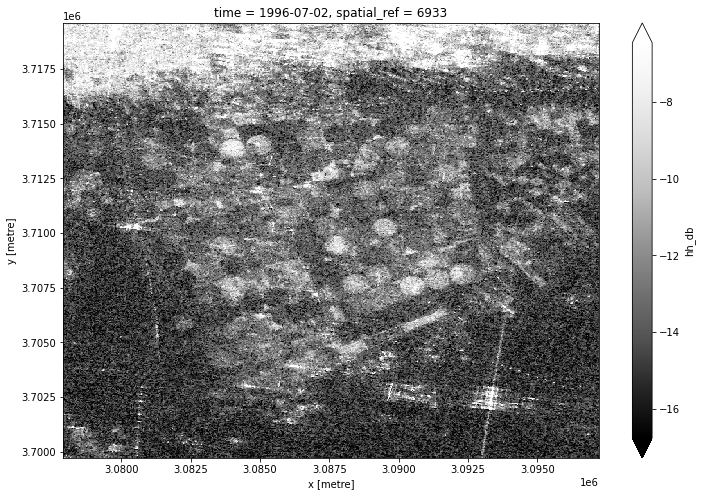

In [16]:
# Plot all VH observations for the year
ds_JERS.hh_db.plot(cmap="Greys_r", robust=True,size=8)
plt.show()

### Histogram Analysis for JERS HH Polarization 

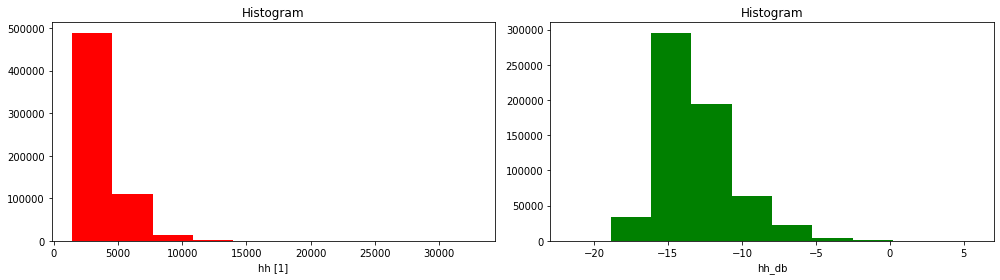

In [17]:
#plotting each polorisation bands following converting to dB values 
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ds_JERS.hh.plot.hist(ax=ax[0], facecolor='red')
ds_JERS.hh_db.plot.hist(ax=ax[1], facecolor='green')
plt.tight_layout()
plt.show()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [18]:
print(datacube.__version__)

1.8.4.dev52+g07bc51a5


**Last Tested:**

In [19]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-04-22'